## 01 Exploratory Data Analysis

### Overview

### Environment

##### Install from requirements.txt

In [ ]:
# Designed for Python 3.11.9
# !python -m pip install -r requirements.txt

##### Install each requirement in notebook

In [ ]:
# Alternative for running in Colab etc
!python -m pip install --upgrade pip

In [ ]:
!python -m pip install ibis-framework[duckdb] --upgrade
!pip install matplotlib=3.9.2
!pip install skforecast==0.14.0
!pip install pmdarima==2.0.4

### Import Data

##### Load Individual Datasets

In [ ]:
import ibis
ibis.options.interactive = True
con = ibis.connect("duckdb://")

In [ ]:
# TODO change this to get data from Github
path = 'data/'

datasets_to_import = {
    'hg':'trading', # US copper on COMEX, USD/pound
    'brent':'trading', # Brent crude oil, USD/barrel
    'umcsent':'non-trading', # US consumer sentiment, as measured by the University of Michigan
}

imported_datasets = {}

for name,frequency in datasets_to_import.items():
    imported_datasets[name,frequency] = ibis.read_csv(path + name,frequency + '.csv')
    print(name,frequency + ': ' + str(imported_datasets[name,frequency].to_pandas().shape))

    

In [150]:
umcsent = data['umcsent']

In [152]:
umcsent.to_pandas().describe(include='all')

,Date,UMCSENT
count,561,561.000000
unique,561,NaN
top,2024-01-09,NaN
freq,1,NaN
mean,NaN,84.771658
std,NaN,13.255908
min,NaN,50.000000
25%,NaN,74.100000
50%,NaN,88.400000
75%,NaN,94.600000


##### Fix Date Columns

All tables must have a 'Date' column

In [ ]:
# Fix UMCSENT
imported_datasets['umcsent'] = imported_datasets['umcsent'].rename(
    dict(Date='DATE'))

##### Merge Datasets

In [ ]:
from typing import Dict
import pandas as pd

# Merge multiple Ibis tables on the specific key
# Adding prefixes to each column based on dataset name 
def merge_tables(
        tables : Dict[str, ibis.Table],
        join_key : str = 'Date',
        join_type : str = 'inner'
    ):

    merged = None

    for dataset_name in tables.keys():
        
        # Get current dataset
        current_dataset = tables[dataset_name]

        # Add prefixes to each column based on the name of the dataset
        names_map = {
            f"{dataset_name}_{col}" : col 
             for col in current_dataset.columns 
             if col != join_key}
        current_dataset = current_dataset.rename(names_map)

        #Base case
        if merged is None:
            merged = current_dataset 
        else:
            # Join the datasets on date
            merged = ibis.join(
                left = merged, 
                right = current_dataset,
                predicates = join_key,
                how = join_type, 
                lname = '{name}', 
                rname = dataset_name + '_{name}') # Rename incoming data - only works if there's a collision 
    
    return merged



In [ ]:
data = merge_tables(imported_datasets, 'Date')

In [ ]:
data.to_pandas().describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,434,434,2014-01-11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hg_Price,434.0,NaN,NaN,NaN,2.167361,1.237198,0.0125,1.009125,2.059,3.272,4.752
hg_Open,434.0,NaN,NaN,NaN,2.163136,1.229705,0.627,1.012,2.05075,3.25725,4.717
hg_High,434.0,NaN,NaN,NaN,2.276164,1.300019,0.654,1.04875,2.185,3.396,5.187
hg_Low,434.0,NaN,NaN,NaN,2.052702,1.15903,0.608,0.97325,1.959,3.066625,4.4685
hg_Vol.,428,415,1.45M,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hg_Change %,434,395,5.02%,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brent_Price,434.0,NaN,NaN,NaN,51.643088,32.84574,10.46,19.8475,48.245,75.3575,139.83
brent_Open,434.0,NaN,NaN,NaN,51.457074,32.769779,10.44,19.6175,47.855,75.1125,140.44
brent_High,434.0,NaN,NaN,NaN,54.931751,34.579993,11.3,20.9,51.74,79.94,147.5


In [148]:
data.to_pandas().select_dtypes(include=np.number).corr()

,hg_Price,hg_Open,hg_High,hg_Low,brent_Price,brent_Open,brent_High,brent_Low,umcsent_UMCSENT
hg_Price,1.000000,0.989195,0.994865,0.995066,0.893382,0.879715,0.887412,0.885412,-0.554303
hg_Open,0.989195,1.000000,0.995272,0.994440,0.897390,0.893749,0.897437,0.892249,-0.559304
hg_High,0.994865,0.995272,1.000000,0.994608,0.893773,0.885914,0.892729,0.886949,-0.565549
hg_Low,0.995066,0.994440,0.994608,1.000000,0.894651,0.883348,0.889607,0.889187,-0.547426
brent_Price,0.893382,0.897390,0.893773,0.894651,1.000000,0.987931,0.993734,0.995978,-0.566844
brent_Open,0.879715,0.893749,0.885914,0.883348,0.987931,1.000000,0.994801,0.991684,-0.570842
brent_High,0.887412,0.897437,0.892729,0.889607,0.993734,0.994801,1.000000,0.992104,-0.579496
brent_Low,0.885412,0.892249,0.886949,0.889187,0.995978,0.991684,0.992104,1.000000,-0.553140
umcsent_UMCSENT,-0.554303,-0.559304,-0.565549,-0.547426,-0.566844,-0.570842,-0.579496,-0.553140,1.000000


##### Dev/Holdout Split 

Split the data into model development (prior to 2018) and final holdout sets (2018 to present)

In [ ]:
dev_data = data
holdout_data = data

### Explore Feature Correlations

##### Feature Correlation Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_correlation_matrix(
        df : pd.DataFrame, 
        figsize=(15,15),
        gridsize=15,
        hexbin_cmap = 'plasma',
        dist_color = 'violet',
        dist_edge_color = 'indigo',
        scatter_color = 'indigo',
        scatter_alpha = 0.3):

    cols = df.columns
    n_cols = len(cols)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_cols, n_cols, figsize=figsize)
    
    # Create plot matrix
    for i in range(n_cols):
        for j in range(n_cols):
            ax = axes[i, j]
            
            # Diagonal: single-feature distribution
            if i == j:
                ax.hist(
                    df[cols[i]], 
                    bins=40,
                    color = dist_color,
                    edgecolor=dist_edge_color)
                ax.set_title(f'Distribution of {cols[i]}')
            
            # Lower triangle: hexbin plots
            elif j < i:
                ax.hexbin(
                        df[cols[j]], 
                        df[cols[i]], 
                        gridsize=gridsize, 
                        cmap=hexbin_cmap, 
                        mincnt=1)
                ax.set_xlabel(cols[j])
                ax.set_ylabel(cols[i])
            
            # Upper triangle: scatterplots
            else:
                ax.scatter(
                        df[cols[j]], 
                        df[cols[i]], 
                        alpha=scatter_alpha,
                        color=scatter_color,
                        edgecolor='none')
                ax.set_xlabel(cols[j])
                ax.set_ylabel(cols[i])
    
    plt.tight_layout()
    plt.show()



In [ ]:
# Example usage
df = pd.DataFrame(np.random.randn(1000, 4), columns=['A', 'B', 'C', 'D'])
plot_feature_correlation_matrix(df)

##### Feature Correlation Matrices

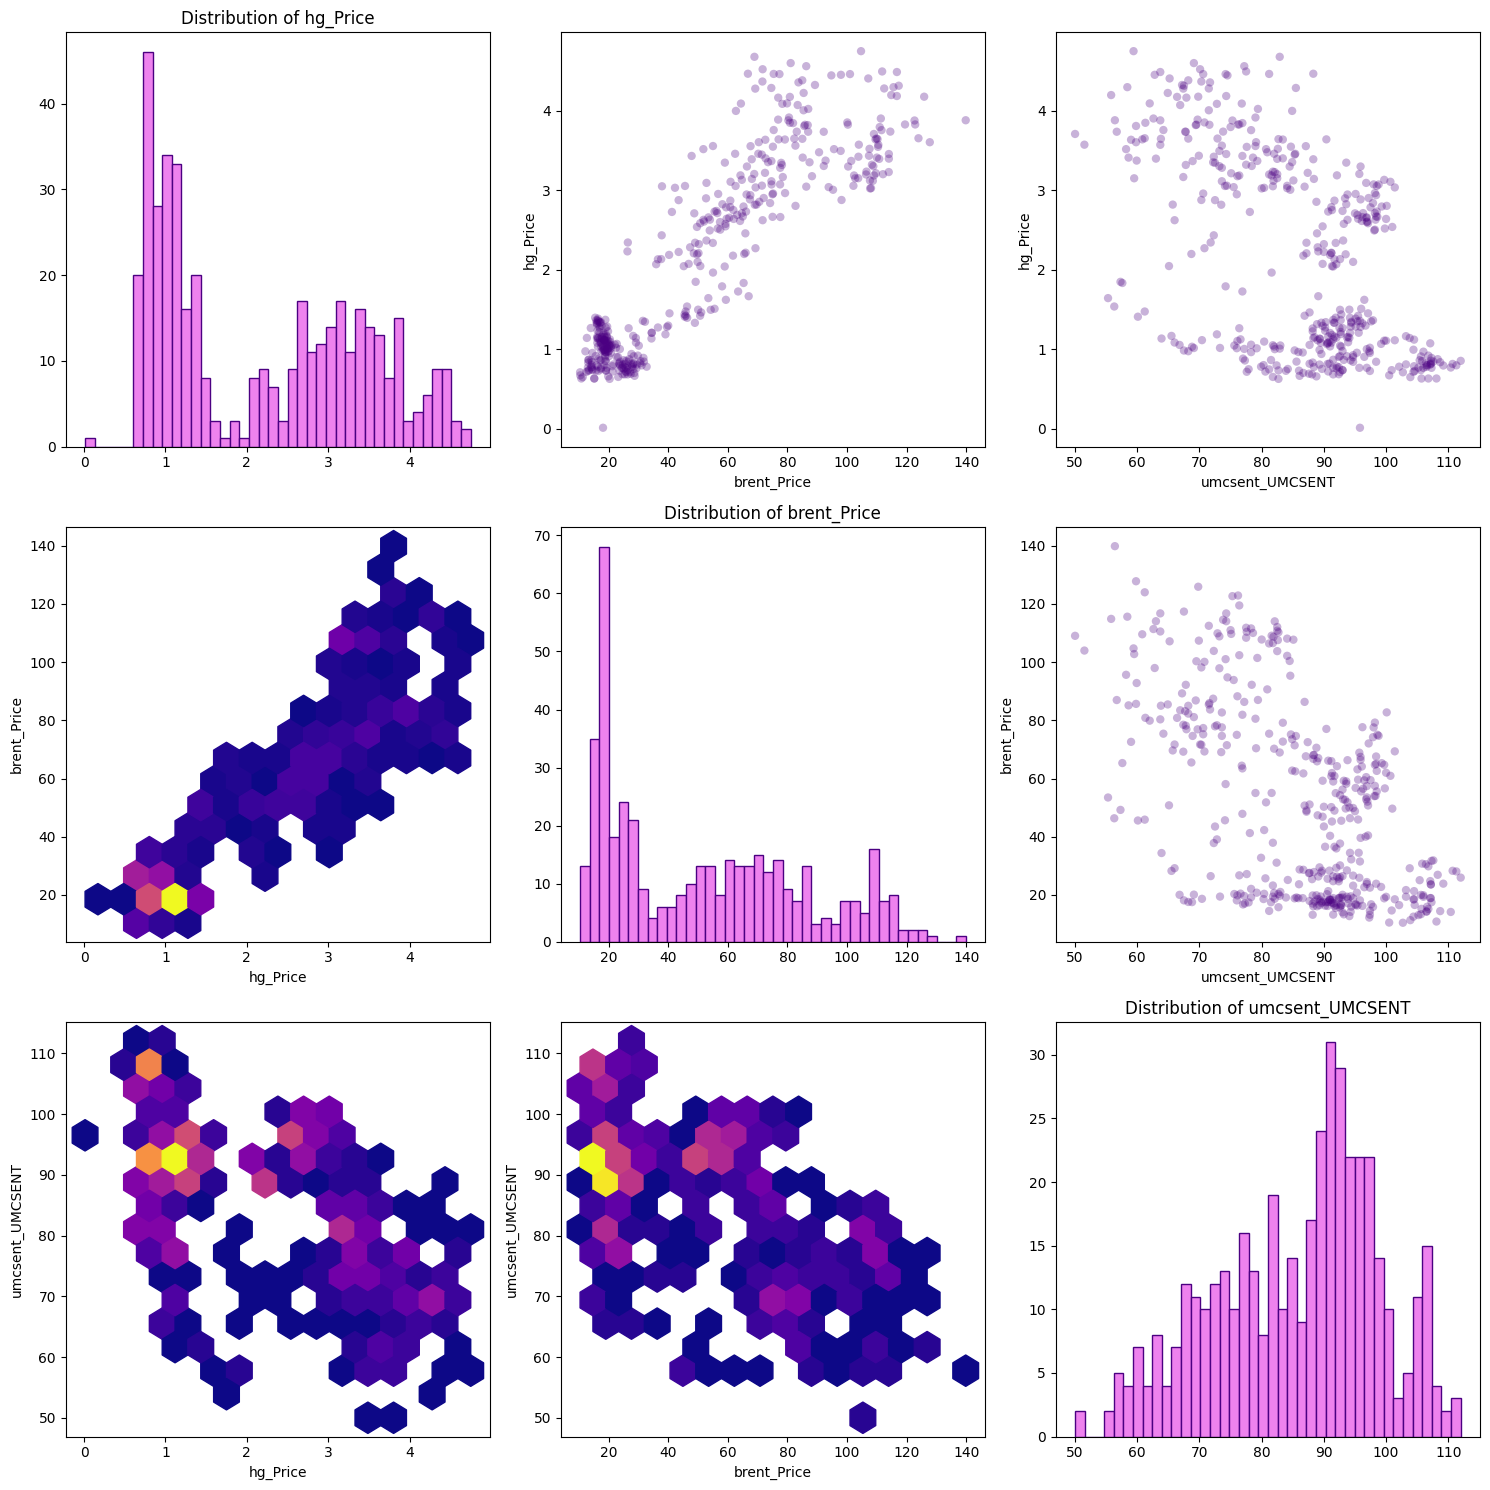

In [ ]:
plot_feature_correlation_matrix(
    data.select(
        'hg_Price',
        'brent_Price',
        'umcsent_UMCSENT'
    ).to_pandas())

### Stationarity Analysis

Features should be stationary, meaning that no significant trends or seasonal patterns should be present in the data.  The mean and variance should be consistent throughout the time period. 


[pmdarima](https://github.com/alkaline-ml/pmdarima) 


In [ ]:
import pmdarima
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import skforecast

In [ ]:
# Load/split your data
y = data
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

### Baseline Models

##### Training

In [ ]:
def prepare_multivariate_data(df, lags=3):
    """
    Prepare multivariate time series data for forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    lags : int, optional (default=3)
        Number of lags to use for features
    
    Returns:
    --------
    X : numpy.ndarray
        Features matrix
    y : numpy.ndarray
        Target values
    """
    # Create lagged features for all series
    X = []
    y = []
    
    for col in df.columns:
        for i in range(len(df) - lags):
            # Create lag features
            lag_features = df.iloc[i:i+lags][col].values
            target = df.iloc[i+lags][col]
            
            X.append(lag_features)
            y.append(target)
    
    return np.array(X), np.array(y)

In [ ]:
def global_multivariate_forecast(df, forecast_horizon=5):
    """
    Perform global multi-series forecasting
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input time series DataFrame
    forecast_horizon : int, optional (default=5)
        Number of steps to forecast
    
    Returns:
    --------
    forecasts : pandas.DataFrame
        DataFrame with forecasts for each series
    """
    # Prepare data
    X, y = prepare_multivariate_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize and train the forecaster
    forecaster = ForecasterAutoreg(
        regressor=LinearRegression(),
        lags=3,
        n_jobs='auto'
    )
    
    # Fit the global model
    forecaster.fit(X_train, y_train)
    
    # Forecast
    forecasts = {}
    for col in df.columns:
        # Forecast for each series
        series_forecast = forecaster.predict(forecast_horizon)
        forecasts[col] = series_forecast
    
    return pd.DataFrame(forecasts)


In [ ]:
import 

In [ ]:
#

##### Experiemental Models

In [ ]:
import pandas as pd
from piml import Experiment
from piml.models import XGB2Classifier